In [1]:
from typing import Annotated, Optional, List, Dict, Any
from langchain_core.messages import ToolMessage, AIMessage, SystemMessage, HumanMessage
from langchain_core.tools import InjectedToolCallId, tool
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable 
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langgraph.types import Interrupt,Command
from pathlib import Path
from dotenv import load_dotenv
import yaml
import json
import re
import textwrap

load_dotenv()

True

In [2]:

# ---------------------------------------------------------------------
# 1 · InputState – what arrives on the very first invoke()
# ---------------------------------------------------------------------
class InputState(BaseModel):
    messages: Annotated[list, add_messages]

# ---------------------------------------------------------------------
# 2 · IntermediateState – everything nodes may read/write
# ---------------------------------------------------------------------
class IntermediateState(BaseModel):
    # flags & classification
    on_topic: Optional[bool] = None

    # employee attributes
    on_project: Optional[int] = None          # 0 = available, 1 = occupied
    tech_stack: Optional[List[str]] = None
    exp: Optional[int] = None
    degree_level: Optional[str] = None

    # HITL bookkeeping
    missing_fields: List[str] = Field(default_factory=list)
    all_fields_present: bool = False
    hitl_pending: Optional[str] = None 

    # SQL / DB
    sql_query: Optional[str] = None
    query_results: List[Dict[str, Any]] = Field(default_factory=list)
    query_params: List[Any] = Field(default_factory=list)   # ← add this line
# ---------------------------------------------------------------------
# 3 · OutputState – what you want back from graph.invoke()
# ---------------------------------------------------------------------
class OutputState(BaseModel):
    results: List[Dict[str, Any]] = Field(default_factory=list)

# ---------------------------------------------------------------------
# 4 · OverallState – single internal schema seen by every node
# ---------------------------------------------------------------------
class OverallState(InputState, IntermediateState, OutputState):
    """Merged state; nodes accept one `state: OverallState` parameter."""
    pass


In [3]:
SYSTEM_PROMPT = """
You are a highly skilled Resource Allocation Agent for a tech company. Your task is to find and suggest the most suitable employees for internal project needs.
You analyze employee attributes such as experience (in years), on_project status (0 = available, 1 = occupied), tech_stack, and degree_level (Bachelor, Master, PhD).
Respond clearly, ask follow‑up questions when needed, and always aim to provide actionable results based on user input.
""".strip()


def _latest_user(state) -> Optional[str]:
    # Helper to fetch the most recent user input message
    for msg in reversed(state.messages):
        if isinstance(msg, HumanMessage):
            return msg.content.strip()
    return None


def start_node(state: OverallState) -> OverallState:
    """
    Initializes the conversation with a system prompt and a welcome message.
    Ensures they're only added once during the first interaction.
    """
    if not any(isinstance(m, SystemMessage) for m in state.messages):
        state.messages.insert(0, SystemMessage(content=SYSTEM_PROMPT))

    if not any(isinstance(m, AIMessage) for m in state.messages):
        state.messages.append(
            AIMessage(content="Hi, I'm your Resource Allocation Agent. How may I assist you today?")
        )
    return state


# LLM-based topic checker chain: classifies if a query is about employee allocation
topic_check_prompt = ChatPromptTemplate([
    ("system", "You are an assistant that checks if a user's message is about employee resource allocation."),
    ("human", "User Query: {user_input}\nRespond with only 'yes' or 'no'.")
])

llm = ChatGroq(model="llama-3.3-70b-versatile")  # LLM model used for all chains
topic_chain = topic_check_prompt | llm | (lambda msg: msg.content.strip().lower())


def topic_checker(state: OverallState) -> dict:
    """
    Uses the topic_chain to determine if the user's message is about resource allocation.
    Returns a boolean flag `on_topic`.
    """
    user_msg = _latest_user(state)
    if not user_msg:
        return {"on_topic": False}

    answer = topic_chain.invoke({"user_input": user_msg})
    answer = answer.strip().lower()
    is_on_topic = "yes" in answer

    print(f"[topic_checker] LLM answered: {answer!r} → on_topic={is_on_topic}")
    return {"on_topic": is_on_topic}


def route_topic(state: OverallState) -> str:
    """
    Graph router function used to determine where to go next based on topic classification.
    Returns the node name as a string.
    """
    return "field_extractor" if state.on_topic else "off_topic"


def off_topic_response(state: OverallState) -> OverallState:
    """
    Responds politely when the user's query is outside the scope of employee allocation.
    """
    state.messages.append(
        AIMessage(content="Sorry, I can only help with employee resource allocation questions.")
    )
    return state


def get_employee_fields(schema_path: str = "schema.yaml") -> List[str]:
    """
    Loads employee field names from a schema YAML file for validation.
    Raises error if schema is missing or incorrectly formatted.
    """
    path = Path(schema_path)
    if not path.exists():
        raise FileNotFoundError(f"Schema file not found: {schema_path}")

    schema = yaml.safe_load(path.read_text())
    if not schema or "employees" not in schema:
        raise ValueError("Invalid schema file: missing 'employees' key.")

    fields = schema["employees"]
    if not isinstance(fields, list) or not all(isinstance(x, str) for x in fields):
        raise ValueError("'employees' must be a list of field names.")

    return fields


EMPLOYEE_FIELDS = ["exp", "tech_stack", "on_project", "degree_level"]  # valid keys for extraction

# Prompt to extract structured fields (like exp, tech_stack) from user query
field_extraction_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are an intelligent assistant that extracts structured field-value "
        "pairs from a user's natural language query. "
        f"The employee table contains the following fields: {', '.join(EMPLOYEE_FIELDS)}. "
        "If the user provides any of these explicitly or implicitly, extract them into a JSON object. "
        "For example, if the user says 'available', map that to `on_project=0`. "
        "Only include keys that are clearly present in the query. For `tech_stack`, return a list."
    ),
    ("human", "{query}")
])

extractor_chain = field_extraction_prompt | llm | (lambda x: x.content.strip())


def _clean_llm_output(raw: str) -> str:
    """
    Cleans up raw LLM output by removing markdown fences and extracting the first JSON block.
    """
    cleaned = textwrap.dedent(raw).strip("` \n")
    match = re.search(r"\{[\s\S]*?\}", cleaned)
    return match.group(0) if match else "{}"


def field_extractor_node(state: OverallState) -> Dict[str, Any]:
    """
    Uses an LLM to extract employee attributes (e.g., exp, tech_stack) from the user's input.
    Also identifies which fields are still missing.
    """
    user_msg = _latest_user(state)
    if not user_msg:
        return {}

    try:
        raw_llm = extractor_chain.invoke({"query": user_msg})
        print("[field_extractor] LLM raw:", raw_llm)
        json_text = _clean_llm_output(raw_llm)
        extracted = json.loads(json_text)
    except Exception as err:
        print(f"[field_extractor] ⚠️ Cannot parse LLM output: {err}")
        extracted = {}

    # Keep only valid employee fields
    updates: Dict[str, Any] = {k: v for k, v in extracted.items() if k in EMPLOYEE_FIELDS}

    # Determine what still needs to be collected from the user
    missing = [f for f in EMPLOYEE_FIELDS if f not in updates]
    updates.update(
        missing_fields=missing,
        all_fields_present=len(missing) == 0,
    )
    return updates


def hitl_node(state: OverallState) -> Dict[str, Any]:
    """
    Human-in-the-loop node: asks the user for any missing fields (like exp or degree_level).
    Adds the response to the state.
    """
    if not state.missing_fields:
        return {}

    field = state.missing_fields[0]
    question = f"Please provide a value for **{field}**:"
    answer = interrupt(question)

    # Normalize types based on field type
    if field in {"on_project", "exp"}:
        try:
            answer = int(answer)
        except Exception:
            pass
    elif field == "tech_stack":
        answer = [tok.strip() for tok in str(answer).split(",") if tok.strip()]

    remaining = state.missing_fields[1:]

    # Return only the updates (LangGraph merges this into full state)
    return {
        field: answer,
        "missing_fields": remaining,
        "all_fields_present": len(remaining) == 0,
        "messages": [
            AIMessage(content=question),
            HumanMessage(content=str(answer)),
        ],
    }


In [4]:
# ---------------------------------------------------------------------------
# 6.  SQL Query Builder
# ---------------------------------------------------------------------------

EMP_TABLE = "employees"  # Table name for employee data

FIELD_TO_COL = {
    "on_project":   "on_project",    # Maps internal field names to DB columns
    "degree_level": "degree_level",
    "exp":          "exp",
    "tech_stack":   "tech_stack",
}

def _array_literal(items: List[str]) -> str:
    """
    Helper to convert a Python list of strings to a PostgreSQL-compatible ARRAY literal.
    Example: ['Python','AWS'] → ARRAY['Python','AWS']
    """
    q = ",".join(adapt(x).getquoted().decode() for x in items)
    return f"ARRAY[{q}]"

def sql_builder(state: OverallState) -> Dict[str, Any]:
    """
    Constructs a parameterized SQL query using fields extracted from the user input.
    Uses different operators depending on the field:
        • `=` for exact matches
        • `>=` for experience
        • `&&` for array overlap (e.g. tech_stack)
    Returns both the SQL query string and the ordered list of parameters.
    """
    where_parts: List[str] = []
    params: List[Any] = []

    for field, col in FIELD_TO_COL.items():
        val = getattr(state, field, None)
        if val is None:
            continue

        if field == "tech_stack":
            where_parts.append(f"{col} && %s")
            params.append(val)                  # list remains as-is
        elif field == "exp":
            where_parts.append(f"{col} >= %s")
            params.append(val)
        else:
            where_parts.append(f"{col} = %s")
            params.append(val)

    query = f"SELECT * FROM {EMP_TABLE} WHERE " + " AND ".join(where_parts)

    # Debug info
    print("SQL :", query)
    print("ARGS:", params)

    return {"sql_query": query, "query_params": params}


# ---------------------------------------------------------------------------
# 7.  DB Executor (psycopg2)
# ---------------------------------------------------------------------------

def db_executor(state: OverallState) -> Dict[str, Any]:
    """
    Executes the SQL query built by `sql_builder` against a PostgreSQL database.
    Handles PostgreSQL-specific formatting like converting lists to ARRAY literals.
    Returns query results as a list of row dictionaries (one per employee).
    Fallbacks to stub data if execution fails.
    """
    import psycopg2
    from psycopg2.extensions import adapt, AsIs
    from database.config_db import discover_databases  # loads DB creds

    try:
        print("In Db Executor")
        db = discover_databases()["employees"]
        conn = psycopg2.connect(
            host=db["host"],
            port=db["port"],
            dbname=db["dbname"],
            user=db["owner"],
            password=db["password"]
        )

        # Prepare parameters, converting any Python list to ARRAY literal
        params = list(getattr(state, "query_params", []))  # copy
        for i, p in enumerate(params):
            if isinstance(p, list):
                lit = ",".join(adapt(x).getquoted().decode() for x in p)
                params[i] = AsIs(f"ARRAY[{lit}]")  # keep as one value

        print("Final SQL :", state.sql_query)
        print("Final ARGS:", params)

        with conn, conn.cursor() as cur:
            cur.execute(state.sql_query, params)
            cols = [d.name for d in cur.description]
            rows = [dict(zip(cols, r)) for r in cur.fetchall()]
            print(rows)

    except Exception as err:
        print(f"[db_executor] ⚠ {err} — using stub data")
        rows = [{
            "id": 999,
            "first_name": "Stub",
            "last_name": "User",
            "on_project": 0,
            "exp": 42,
            "tech_stack": ["python", "sql"],
            "degree_level": "PhD",
        }]

    return {"query_results": rows}


# ---------------------------------------------------------------------------
# 8.  Response Builder
# ---------------------------------------------------------------------------

def response_builder(state: OverallState) -> Dict[str, Any]:
    """
    Converts query results into a readable bullet list of employee recommendations.
    Adds this as an AIMessage to the chat and includes the raw rows in `results`.
    """
    rows: List[Dict[str, Any]] = state.query_results or []

    if not rows:
        reply = "No matching employees were found."
    else:
        bullets = [
            f"• {r.get('first_name','?')} {r.get('last_name','?')} "
            f"({r.get('exp','?')} yrs, stack: {', '.join(r.get('tech_stack', []))})"
            for r in rows
        ]
        reply = "Here are the best‑matched employees:\n" + "\n".join(bullets)

    return {
        "messages": [AIMessage(content=reply)],
        "results": rows
    }


In [5]:
def route_after_extractor(state: OverallState) -> str:
    """
    Router called **immediately after `field_extractor_node`**.

    • If `all_fields_present` is True
        → we already have every attribute we need  
          (exp, tech_stack, on_project, degree_level)  
          ⇒ go straight to **sql_builder**.

    • Otherwise
        → at least one attribute is missing  
          ⇒ drop into the **hitl** (human‑in‑the‑loop) node to ask the user.
    """
    return "sql_builder" if state.all_fields_present else "hitl"


def route_after_hitl(state: OverallState) -> str:
    """
    Router used right after the HITL node resumes.

    • If the most recent answer completed the set of required fields
        ⇒ proceed to **sql_builder**.

    • If some fields are still missing
        ⇒ loop back to **hitl** to ask the next follow‑up question.

    This simple two‑way router keeps looping until
    `state.all_fields_present` becomes True.
    """
    return "sql_builder" if state.all_fields_present else "hitl"


In [6]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

# ---------------------------------------------------------------------
# 1 · Initialise the builder with overall / I‑O schemas
# ---------------------------------------------------------------------
builder = StateGraph(
    OverallState,           # internal state
    input=InputState,
    output=OverallState     # ← change here
)


# ---------------------------------------------------------------------
# 2 · Register all nodes (single‑arg versions)
# ---------------------------------------------------------------------
builder.add_node("start",            start_node)
builder.add_node("topic_checker",    topic_checker)
builder.add_node("off_topic",        off_topic_response)   # new branch
builder.add_node("field_extractor",  field_extractor_node)
builder.add_node("hitl",             hitl_node)
builder.add_node("sql_builder",      sql_builder)
builder.add_node("db_executor",      db_executor)
builder.add_node("response_builder", response_builder)

# ---------------------------------------------------------------------
# 3 · Wire edges
# ---------------------------------------------------------------------
builder.add_edge(START, "start")                 # entry
builder.add_edge("start", "topic_checker")

# 3.1 conditional route: on‑topic vs off‑topic
builder.add_conditional_edges(
    "topic_checker",
    route_topic,                                 # returns "on_topic"/"off_topic"
    path_map=["field_extractor", "off_topic"]    # must match the return values
)                                                # :contentReference[oaicite:0]{index=0}

# 3.2 field extractor → SQL or HITL
builder.add_conditional_edges(
    "field_extractor",
    route_after_extractor,                       # returns "sql_builder"/"hitl"
    path_map=["sql_builder", "hitl"]
)                                                # :contentReference[oaicite:1]{index=1}

# 3.3 HITL loop
builder.add_conditional_edges(
    "hitl",
    route_after_hitl,
    path_map=["sql_builder", "hitl"]
)                                                # :contentReference[oaicite:2]{index=2}

# 3.4 straight edges for DB & reply
builder.add_edge("sql_builder", "db_executor")
builder.add_edge("db_executor", "response_builder")

# 3.5 terminal edges
builder.add_edge("off_topic", END)
builder.add_edge("response_builder", END)

# ---------------------------------------------------------------------
# 4 · Compile with an in‑memory checkpointer
# ---------------------------------------------------------------------
graph = builder.compile(checkpointer=MemorySaver())        # :contentReference[oaicite:3]{index=3}


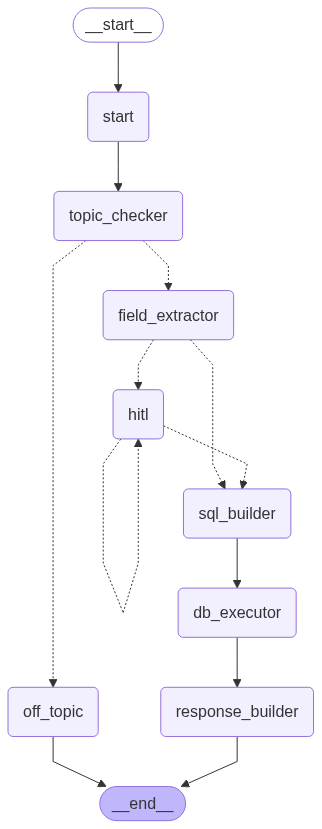

In [7]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [8]:
# ──────────────────────────────────────────────────────────────────────────────
# Driver / test loop – paste this into a fresh cell
# ──────────────────────────────────────────────────────────────────────────────
import builtins                                    # gives us builtins.input
from langgraph.types import Command                # already used for resume
from langchain_core.messages import HumanMessage   # convenience

# ---- kick off the first turn -------------------------------------------------
state = {
    "messages": [
        HumanMessage(content="Find an employee who is good in Python, FastAPI, AWS with 4 year of exp")
    ]
}
#Find an employee with 5 yrs exp and good hold in ML
#Find an employee who is good in Python, FastAPI, AWS with 4 year of exp
result = graph.invoke(state, config={"configurable": {"thread_id": "demo"}})

# ---- handle any HITL pauses --------------------------------------------------
while "__interrupt__" in result:
    # grab the prompt the HITL node produced
    prompt = result["__interrupt__"][0].value + " "
    # ask the real user for the missing value
    user_answer = builtins.input(prompt)
    # resume the graph with that answer
    result = graph.invoke(
        Command(resume=user_answer),
        config={"configurable": {"thread_id": "demo"}}
    )

# ---- dump the final chat -----------------------------------------------------
for msg in result["messages"]:
    print(type(msg).__name__, "→", msg.content)


[topic_checker] LLM answered: 'yes' → on_topic=True
[field_extractor] LLM raw: ```json
{
  "exp": 4,
  "tech_stack": ["Python", "FastAPI", "AWS"]
}
```
SQL : SELECT * FROM employees WHERE on_project = %s AND degree_level = %s AND exp >= %s AND tech_stack && %s
ARGS: [1, 'Bachelor', 4, ['Python', 'FastAPI', 'AWS']]
In Db Executor
Final SQL : SELECT * FROM employees WHERE on_project = %s AND degree_level = %s AND exp >= %s AND tech_stack && %s
Final ARGS: [1, 'Bachelor', 4, <psycopg2.extensions.AsIs object at 0x0000015F1BF65E50>]
[{'id': 1, 'first_name': 'Alice', 'last_name': 'Smith', 'email_id': 'alice.smith@gmail.com', 'on_project': 1, 'tech_stack': ['Python', 'FastAPI', 'AWS'], 'exp': 4, 'degree_level': 'Bachelor'}]
HumanMessage → Find an employee who is good in Python, FastAPI, AWS with 4 year of exp
SystemMessage → You are a highly skilled Resource Allocation Agent for a tech company. Your task is to find and suggest the most suitable employees for internal project needs.
You analyz